In [1]:
%reload_ext nb_black

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

There's some `order` data in this directory.  Find it, and read it into a dataframe.

In [3]:
df = pd.read_csv("data/orders.csv")
df = df.drop(columns=["Unnamed: 0"])
df

,product_id,state,date,rating,units_sold,price
0,5,ID,2010-02-05,*,6.0,$4.73
1,4,FL,2010-02-07,****,7.0,NaN
2,1,NY,2010-02-07,*,NaN,$23.81
3,7,HI,2010-03-12,*,4.0,$21.78
4,5,NY,2010-04-07,****,6.0,$4.73
...,...,...,...,...,...,...
208,8,GA,2019-11-03,*****,211.0,$15.42
209,1,TN,2019-11-13,*,NaN,$23.81
210,6,CA,2019-11-15,**,219.0,$2.38
211,9,GA,2019-12-10,*,219.0,$17.98


<IPython.core.display.Javascript object>

Inspect the data frame with the `.info()` method.  Where do we have nans?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product_id  213 non-null    int64  
 1   state       213 non-null    object 
 2   date        213 non-null    object 
 3   rating      187 non-null    object 
 4   units_sold  187 non-null    float64
 5   price       185 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 10.1+ KB


<IPython.core.display.Javascript object>

In [5]:
"""
- continuous
- categorical
    *nominal
    *ordinal (will treat as numbers once converted)
"""

'\n- continuous\n- categorical\n    *nominal\n    *ordinal (will treat as numbers once converted)\n'

<IPython.core.display.Javascript object>

In [6]:
"""
product_id - technically an int but ids pretty much always drop 
state - technically a str but for ML we might call this categorical - nominal
date - technically a str right now, but should be converted to a date
rating - technically a str but for ML we might call this categorical
units_sold - 
price - 
"""

'\nproduct_id - technically an int but ids pretty much always drop \nstate - technically a str but for ML we might call this categorical - nominal\ndate - technically a str right now, but should be converted to a date\nrating - technically a str but for ML we might call this categorical\nunits_sold - \nprice - \n'

<IPython.core.display.Javascript object>

Further inspect the data frame with `.isna()` or `.isnull()`

What percentage of each column is `NaN`?

In [7]:
# sum number of nulls
df.isnull().sum()

product_id     0
state          0
date           0
rating        26
units_sold    26
price         28
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
# mean of nulls, shows percentage of overall data that has nulls
# may not be best to drop for different reasons
df.isnull().mean()

product_id    0.000000
state         0.000000
date          0.000000
rating        0.122066
units_sold    0.122066
price         0.131455
dtype: float64

<IPython.core.display.Javascript object>

Convert the price column to numeric

In [9]:
# check if any other currencies in dataset
# (assuming first character is currency symbol)
df.price.str.slice(0, 1).value_counts()

$    185
Name: price, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
# takes the "$ off the price"
df.price = df.price.str.strip("$")
df.price = pd.to_numeric(df.price)

<IPython.core.display.Javascript object>

Using `pd.to_numeric` with the option `errors="coerce"` can create new `NaN`s. 

Redo the same missing value analysis.

In [11]:
df.isnull().sum()

product_id     0
state          0
date           0
rating        26
units_sold    26
price         28
dtype: int64

<IPython.core.display.Javascript object>

Convert the ratings column to numeric.

In [12]:
df.rating.value_counts()

*        41
**       39
***      38
*****    37
****     32
Name: rating, dtype: int64

<IPython.core.display.Javascript object>

In [13]:
# count char method

# df.rating.apply(len) - fails complaining about NaN values that are floats
df.rating = df.rating.str.len()

<IPython.core.display.Javascript object>

In [14]:
# replace method
# mapping = {"*": 1, "**": 2, "***": 3, "****": 4, "*****": 5}
# df.rating.replace(mapping)

TypeError: Cannot compare types 'ndarray(dtype=float64)' and 'str'

<IPython.core.display.Javascript object>

Convert the date column to a date datatype and sort by it

In [15]:
df.date = pd.to_datetime(df.date)

<IPython.core.display.Javascript object>

In [16]:
# why special datetime data type?
df.date.dt.quarter

0      1
1      1
2      1
3      1
4      2
      ..
208    4
209    4
210    4
211    4
212    4
Name: date, Length: 213, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213 entries, 0 to 212
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   product_id  213 non-null    int64         
 1   state       213 non-null    object        
 2   date        213 non-null    datetime64[ns]
 3   rating      187 non-null    float64       
 4   units_sold  187 non-null    float64       
 5   price       185 non-null    float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 10.1+ KB


<IPython.core.display.Javascript object>

Now let's address the missing values.

In practice, the 2 main ways we might handle NAs are:

* Drop them
* Fill them in with a value
  * Some people didn't mark their height on a survey, maybe we fill in with the average height reported
  * The thermeter broke so we're missing a temperature at time 4, maybe we fill it in with the average of time 3 and time 5 (linear interpolation)


Before dropping we'd like to know why the values are NA because we might be dropping valid data.  For example, you might have seen something like below on a survey:

> 10. Are you a veteran?:  &emsp;&emsp; Yes [&emsp;]&emsp;&emsp;No [&emsp;]
> 
> (only answer the following questions if you answered yes to question 10)

In this case, we should expect non-veterans to have missing values to the veteran only questions.  Other times, missing values aren't that deep and they're just missing.  For example, maybe a survey taker didn't know there was a page 2 so they left it all blank.

In practice it's very important to know how the data was collected and what a missing value indicates.

* Is there any pattern to any of the missingness?

In [18]:
# checks for any null values in all the columns
df.isna().any()

product_id    False
state         False
date          False
rating         True
units_sold     True
price          True
dtype: bool

<IPython.core.display.Javascript object>

In [19]:
# not missing at random
# only missing when product_id is zero
df.loc[df.rating.isna(), :].head()

,product_id,state,date,rating,units_sold,price
7,0,OR,2010-06-13,NaN,NaN,9.98
11,0,HI,2010-08-04,NaN,NaN,9.98
37,0,TN,2011-11-22,NaN,40.0,9.98
64,0,OR,2013-02-25,NaN,73.0,9.98
69,0,CA,2013-05-16,NaN,76.0,9.98


<IPython.core.display.Javascript object>

In [20]:
missing_price = df.loc[df.price.isna(), :]
missing_price.units_sold.value_counts().head()

144.0    2
204.0    1
120.0    1
13.0     1
46.0     1
Name: units_sold, dtype: int64

<IPython.core.display.Javascript object>

We want to move forward with a dataframe that doesn't have any missing values.

* What options do we have?
* Which ones make sense for each column?
    * How do we decide which ones make sense?
    
Once these questions are answered.  Let's apply them until we have no missing values.

In [22]:
# dropping totally fair, no info to go off of for product 0
# typical rating

# If product 0 is of big importance to the analysis
# then dropping might not be an option

# Maybe replace with average rating but consider distribution of ratings first
df.loc[df.rating.isna(), :].head()

,product_id,state,date,rating,units_sold,price
7,0,OR,2010-06-13,NaN,NaN,9.98
11,0,HI,2010-08-04,NaN,NaN,9.98
37,0,TN,2011-11-22,NaN,40.0,9.98
64,0,OR,2013-02-25,NaN,73.0,9.98
69,0,CA,2013-05-16,NaN,76.0,9.98


<IPython.core.display.Javascript object>

In [24]:
# dropping option
df = df.dropna(subset=["rating"])

<IPython.core.display.Javascript object>

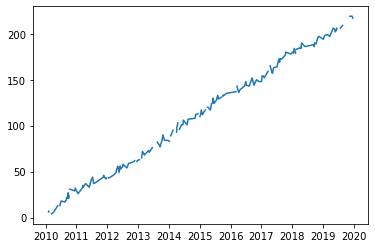

<IPython.core.display.Javascript object>

In [26]:
plt.plot(df.date, df.units_sold)
plt.show()

In [28]:
df = df.sort_values("date")
df

,product_id,state,date,rating,units_sold,price
0,5,ID,2010-02-05,1.0,6.0,4.73
1,4,FL,2010-02-07,4.0,7.0,NaN
2,1,NY,2010-02-07,1.0,NaN,23.81
3,7,HI,2010-03-12,1.0,4.0,21.78
4,5,NY,2010-04-07,4.0,6.0,4.73
...,...,...,...,...,...,...
208,8,GA,2019-11-03,5.0,211.0,15.42
209,1,TN,2019-11-13,1.0,NaN,23.81
210,6,CA,2019-11-15,2.0,219.0,2.38
211,9,GA,2019-12-10,1.0,219.0,17.98


<IPython.core.display.Javascript object>

In [32]:
# forward fill: take the last value and fill it in to the next
df.units_sold.fillna(method="ffill")

# back fill: take the next value and enter it in the value before that
df.units_sold.fillna(method="bfill")

# linear interpolation
df.units_sold = df.units_sold.interpolate()

# results in partial units sold; will that cause any issues later? Should rounding be done?

<IPython.core.display.Javascript object>

In [33]:
df.isna().sum()

product_id     0
state          0
date           0
rating         0
units_sold     0
price         25
dtype: int64

<IPython.core.display.Javascript object>

* DataTypes
    * Categorical vs. Numeric
        * Cats = 
            * nominal (names); tbd convert to dummy/onehotencoded variables
            * ordinal (ordered labels); converted to numbers
        * Nums =
            * discrete
            * continuous
                * treat price much the same
* Missingness
    * don't blindly drop NAs in the real world
    * are missing values related to anything?
        * always missing rating for certain product? Certain day?
    * How to fill NAs if not dropping
        * time based approach? ffill, bfill, interpolate
        * fill with avg/median
        * fill with another calculated variable
        
        * if categorical, what do the patterns show?
        
    * Drop as a last resort